In [35]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp
import plotly.graph_objects as go
# %matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts

In [36]:
# load acetate simulation output
time = '400'
date = '2025-02-26'
experiment = 'NEW'
condition = 'acetate'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_acetate = output['listeners']['fba_results']
bulk_acetate = pd.DataFrame(output['bulk'])
mass_acetate = output['listeners']['mass']
f = open(folder + 'agent_steps.pkl', 'rb')
agent_acetate = dill.load(f)
f.close()

In [37]:
# load basal simulation output
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_basal = output['listeners']['fba_results']
mass_basal = output['listeners']['mass']
bulk_basal = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

In [38]:
# get commonly stored variables
metabolism_acetate = agent_acetate['ecoli-metabolism-redux-classic']
metabolism = agent_basal['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry
reaction_names = metabolism.reaction_names
kinetic_reaction_ids = metabolism.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism.binary_kinetic_idx

## Create Dataframe

In [39]:
# all reactions
sim_acetate = pd.DataFrame(fba_acetate["estimated_fluxes"], columns= reaction_names).mean(axis=0)
sim_basal = pd.DataFrame(fba_basal["estimated_fluxes"], columns= reaction_names).mean(axis=0)

# kinetic reactions
kc_target_acetate = pd.DataFrame(fba_acetate["target_kinetic_fluxes"], columns= kinetic_reaction_ids).mean(axis=0)
kc_target_basal = pd.DataFrame(fba_basal["target_kinetic_fluxes"], columns= kinetic_reaction_ids).mean(axis=0)

# deal with zero fluxes
sim_acetate += 1e-6
sim_basal += 1e-6
kc_target_acetate += 1e-6
kc_target_basal += 1e-6

sim_acetate = np.log10(sim_acetate)
sim_basal = np.log10(sim_basal)
kc_target_acetate = np.log10(kc_target_acetate)
kc_target_basal = np.log10(kc_target_basal)

In [40]:
# create all and kc reaction dataframe
df_all = pd.DataFrame({'sim_acetate': sim_acetate, 'sim_basal': sim_basal, 'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in reaction_names]})
df_kc  = pd.DataFrame({'kc_target_acetate': kc_target_acetate, 'kc_target_basal': kc_target_basal, 'sim_acetate_kc_sim': sim_acetate[kinetic_reaction_ids],
                       'sim_basal_kc_sim': sim_basal[kinetic_reaction_ids],
                       'is_new': ['New Reactions' if id in fba_new_reaction_ids else 'Old Reactions' for id in kinetic_reaction_ids]})
df_kc.loc[df_kc.is_new == 'New Reactions', 'old_kc_target'] = np.log10(1e-6)
# set up plotly parameters
category_colors = {
    'Old Reactions': "purple",
    'New Reactions': "yellow",
}

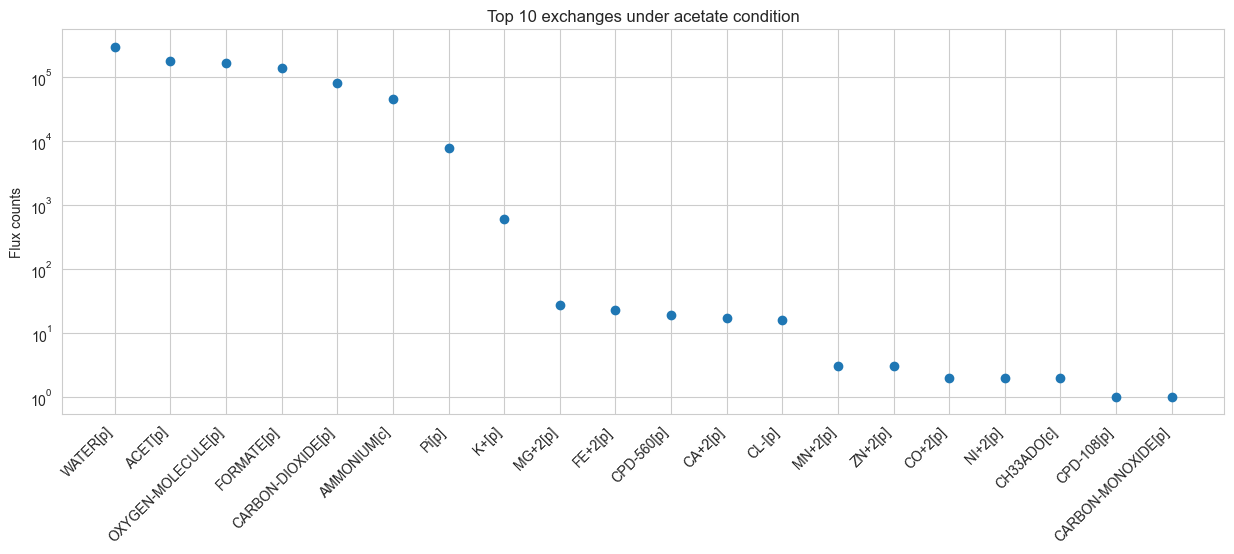

In [41]:
%matplotlib inline
sim_exchanges = pd.DataFrame(fba_acetate["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges under acetate condition')
plt.show()

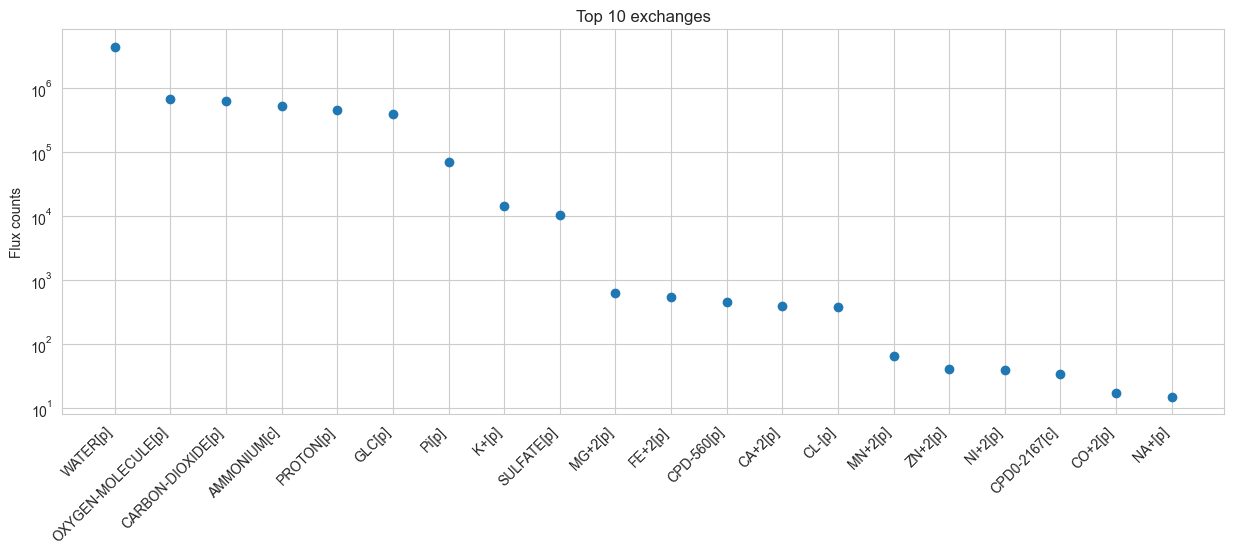

In [42]:
sim_exchanges = pd.DataFrame(fba_basal["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges')
plt.show()